## 5- Next Best Action

Now, we have our models that allows us to compute needs'prediction for a client. The final step is to create a simple recommandation system for the seller, which use our models to detect a need or a not need of a client and then recommend to him the next best action. To do it, we will:
- Predict the client need (Accumulation, Investment, both or none)
- Match the prediction with the product type (if we do not have a need, we stop here)
- Match the product risk with the client risk
- Propose a list of products

So let us start.

In [ ]:
#Classical libraries
import pandas as pd
import seaborn as sns

#Our functions
%cd ..
from src.nbaFnct import *

First, we have to import the products dataset and the clients dataset to visualize them with some plots. 

In [2]:
# Restore the dataset
%store -r dataset

[Text(0.5, 1.0, 'RiskPropensity for client with Income need')]

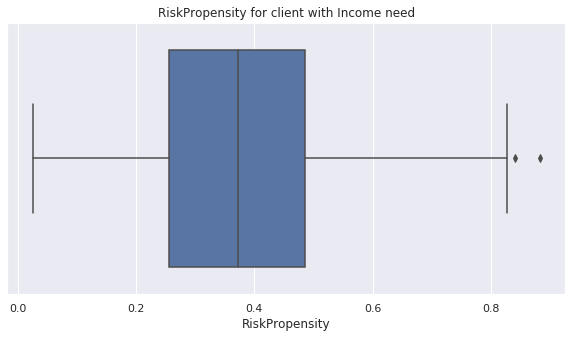

In [3]:
riskIncomeClient = dataset[(dataset.values[:,5]==1)]["RiskPropensity"] #Positive Income target
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(x=riskIncomeClient).set(title="RiskPropensity for client with Income need")

Here is the box plot of risk propensity for clients who have an income need. It is a normalised score, from 0 to 1, which evaluate the client risk. The minimum level of risk is 0.02 and the maximum is 0.88.

We have 50% of client risk which are between 0.25 and 0.48 with the median at 0.37.

We can also see that we have two outliers datas, include the maximum risk at 0.88.

[Text(0.5, 1.0, 'RiskPropensity for client with Accumulation need')]

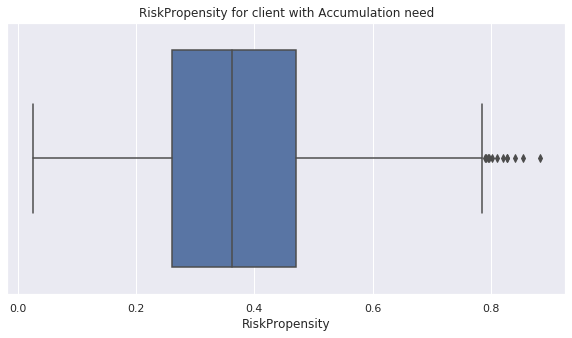

In [4]:
riskAccumulationClient = dataset[(dataset.values[:,6]==1)]["RiskPropensity"] #Positive Accumulation target
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(x=riskAccumulationClient).set(title="RiskPropensity for client with Accumulation need")

Here is the box plot of risk propensity for client who have accumulation need. Again, the minimum value is 2% and the maximum is 88%. We also have some extrem values a bit before 80%.

According to the box plot, 50% of the risk scores is between 26 and 47% with a median at 36%.

Now, let us see the histogram of the risk propensity. 

[Text(0.5, 1.0, 'Histogram of RiskPropensity for Income target distribution')]

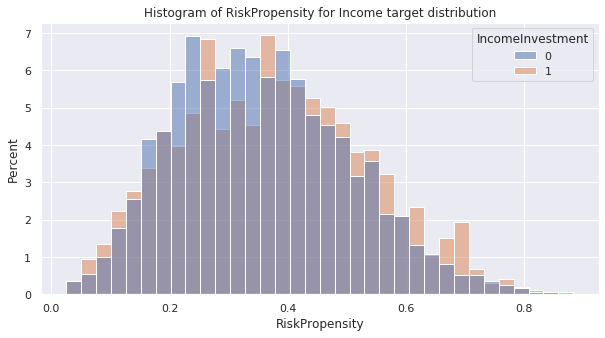

In [5]:
# Histogram of RiskPropensity by IncomeInvestment
sns.set(rc = {'figure.figsize':(10,5)})
sns.histplot(x="RiskPropensity", data=dataset, hue="IncomeInvestment", stat="percent", common_norm=False).set(title="Histogram of RiskPropensity for Income target distribution")

This grah is the histogram of the feature **RiskPropensity** for positive (in orange) and negative (in blue) target *IncomeInvestment* normalized in percentage.

We can see that globaly, the distribution for positive and negative target are quite similar.

For the lower risk (under 0.2) the distribution for the positive target is a little bit superior (except for one case) but positive and negative target follow the same dynamic. 

For the risk between 0.2 and 0.4, the distribution for negative target are more higher. For the risk above 0.4, the distribution of positive target is superior, especially for some value.

[Text(0.5, 1.0, 'Histogram of RiskPropensity for Accumulation target distribution')]

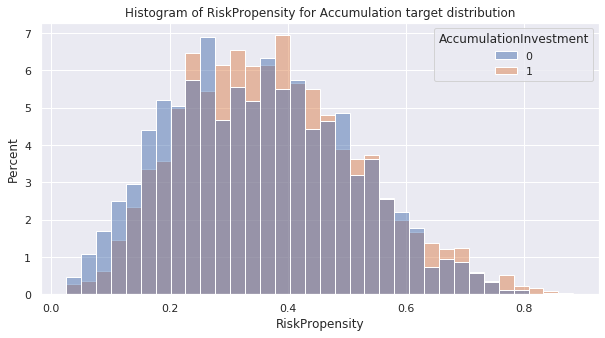

In [6]:
# Histogram of RiskPropensity by AccumulationInvestment
sns.set(rc = {'figure.figsize':(10,5)})
sns.histplot(x="RiskPropensity", data=dataset, hue="AccumulationInvestment", stat="percent", common_norm=False).set(title="Histogram of RiskPropensity for Accumulation target distribution")

Here again, this grah is the histogram of the feature **RiskPropensity** for positive and negative target *AccumulationInvestment* normalize in percentage.

For the risk under 0.2, the distribution of negative target is superior than the positive one. The dynamic for the negative ones is superior than the positive one.

For the risk between 0.2 and 0.5, the distribution of positive target take the lead and the dynamics is completly different.

Then, for the risk above 0.5, the dynamics of positive and negative target distribution are similar and also the distribution.

Now, we will analyse the dataset of the different products.

In [7]:
# Dataset of the product
xls = pd.ExcelFile('src/Needs.xls')
productsData = pd.read_excel(xls, 'Products', index_col=0)
# Income and Accumulation products dataset
ProductInc = productsData[productsData["Type"]==0].sort_values(by=['Risk'], ascending=False)
ProductAcc = productsData[productsData["Type"]==1].sort_values(by=['Risk'], ascending=False)

In [8]:
print(ProductAcc)

           Type  Risk
IDProduct            
11            1  0.88
7             1  0.75
1             1  0.55
8             1  0.48
5             1  0.41
6             1  0.36
9             1  0.27


This is the dataset of accumulation products (type = 1). It has 7 products. The risks go from 0.27 to 0.88.

We can see that the risk level is more higher (more than 25% of the clients have a risk propensity bellow 0.27!).

We know that 75% of clients with an accumulation need have a risk propensity under 0.47. Here, we have 4 products above this threshold.

We also know that the maximum risk propensity is a little bit higher than 0.88 and here we have a product with a risk at 0.88.

We will have to take into account these observations for the Accumulation recommandation system.

In [9]:
print(ProductInc)

           Type  Risk
IDProduct            
4             0  0.44
2             0  0.30
10            0  0.13
3             0  0.12


This is the dataset of income products (type = 0). It has only 4 products, less than the accumulation one, and we can see that the risk is not so high the maximum is 0.44.

With this level of risk, we can imagine that each client will have a product which can respect their risk propensity.

Two product, id 3 and 10, have a similar risk (0.12 and 0.13). We will have to take into account for the recommandation.

### Recommandation System

Now that we saw the datas, we will build our recommandation system. The idea is to predict a need of a client and then recommande with a probability a list of products.

The probability is based on the distance between the product risk and the client risk. Let us see what it gives.

In [ ]:
#Load the model
%store -r modIncome
%store -r modAccumulation

#Load the mean and std
%store -r data_mean
%store -r data_std

To illustrate our recommandation system, we will create a fictitious sample that has an income and accumulation need. Then, we will show how our recommendation works.

First of all, we create our fake sample and verify that it has income and accumulation need.

In [11]:
#Let create a fake sample
age = 63; FinancialEduc = 0.7645; Riskpropensity = 0.5367; logIncome = 5.113; logWealth = 6.00345
data = [age, FinancialEduc/Riskpropensity, logIncome, logWealth]
print(incomePred(data_mean, data_std, modIncome, data))
print(accumulationPred(data_mean, data_std, modIncome, data))

[ True]
[ True]


Our fictitious client has the right needs, now let us see how the recommandation system works for these need.

In [12]:
recommandationSys(Riskpropensity, ProductInc, ProductAcc, data_mean, data_std, modIncome, modAccumulation, data)

We predict you an income need.
We recommande you the product more risky n° 4 with a probability of 0.7099580083983204
We recommande you the product more risky n° 2 with a probability of 0.29004199160167954

We predict you an accumulation need.
We recommande you the product more risky n° 8 with a probability of 0.19000000000000106
We recommande you the product more risky n° 1 with a probability of 0.8099999999999989


Here, we can see that it detect the need. Then it lists the product, more or less risky than the client risk, and gives the probability of the right product to the client.

### Conclusion

We create two models to predict income and accumulation need. For that we started by visualizing our data to try to have a first idea.

Then we pre-process our dataset to prepare the data for our model. After that we train some models and select the best ones before try to understand them thanks to global and local interpretability techniques.

To finish, we implement a personal recommandation system for financial product based on the models that we train and clients'data.
  
</br>
During this process, we make a lot of choices (on metrics, on feature selection, on model algorithm choice, ...) that we can discuss about or modify (see the annexe).

It learn us that is the main concept for the implementation of a Machine Learning model: make a lot of tests based on our knowledges and our intutions, then make a choice according to these tests and the different constraints that we can have. We try to keep some intersting idea that we choose to not develop more in the annexe.

During this project, we try to applied all the notions that we have seen during the lectures which allow us to have a better comprehension.

At the end, even if we can improve our work, we can say that we learn a lot with this business case and we succes to perform the more important tasks which are asked. 